# THIS NOTEBOOK:
### Analyze the Customer Service Tweets on Twitter
#### (The Kernel 'https://www.kaggle.com/psbots/customer-support-meets-spacy-universe' was used while creating this notebook )

Content
The dataset is a CSV, where each row is a tweet. The different columns are described below. Every conversation included has at least one request from a consumer and at least one response from a company. Which user IDs are company user IDs can be calculated using the inbound field.

tweet_id: 
A unique, anonymized ID for the Tweet. Referenced by response_tweet_id and in_response_to_tweet_id.

author_id: 
A unique, anonymized user ID. @s in the dataset have been replaced with their associated anonymized user ID.

inbound: 
Whether the tweet is "inbound" to a company doing customer support on Twitter. This feature is useful when re-organizing data for training conversational models.

created_at: 
Date and time when the tweet was sent.

text: 
Tweet content. Sensitive information like phone numbers and email addresses are replaced with mask values like __email__.

response_tweet_id: 
IDs of tweets that are responses to this tweet, comma-separated.

in_response_to_tweet_id: 
ID of the tweet this tweet is in response to, if any.

### Created By: George J. Conidis || Created On: January 25th, 2020 || Last Modified: January 25th, 2020

In [1]:
import re
import os
import numpy as np
import pandas as pd
import matplotlib
#matplotlib.style.use('ggplot') ## G: removed and replaced with the code two lines below
import matplotlib.pyplot as plt
plt.style.use('ggplot')
width = 0.75
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.axis('off')
from nltk.corpus import stopwords
from textblob import TextBlob
import scattertext as st
import spacy
import spacy_cld

## Setting up the language detector for English (disabeling the tagger and ner) and creating
# the pipeline
nlp_cld = spacy.load('en',disable_pipes=["tagger","ner"])
language_detector = spacy_cld.LanguageDetector()
nlp_cld.add_pipe(language_detector)

from IPython.display import IFrame
from IPython.core.display import display, HTML
from collections import Counter
from tqdm import tqdm_notebook as tqdm  # cool progress bars
tqdm().pandas()  # Enable tracking of progress in dataframe `apply` calls


# Ensure the Jupyter Notebooks fills the web browser
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/home/george/anaconda3/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [ ]:
# Feature Engineering Functions
def feature(df) :
    df['word_count'] = df['comment_text'].apply(lambda x : len(x.split()))
    df['char_count'] = df['comment_text'].apply(lambda x : len(x.replace(" ","")))
    df['word_density'] = df['word_count'] / (df['char_count'] + 1)
    df['punc_count'] = df['comment_text'].apply(lambda x : len([a for a in x if a in punc]))
    df['total_length'] = df['comment_text'].apply(len)
    df['capitals'] = df['comment_text'].apply(lambda comment: sum(1 for c in comment if c.isupper()))
    df['caps_vs_length'] = df.apply(lambda row: float(row['capitals'])/float(row['total_length']),axis=1)
    df['num_exclamation_marks'] =df['comment_text'].apply(lambda x: x.count('!'))
    df['num_question_marks'] = df['comment_text'].apply(lambda x: x.count('?'))
    df['num_punctuation'] = df['comment_text'].apply(lambda x: sum(x.count(w) for w in '.,;:'))
    df['num_symbols'] = df['comment_text'].apply(lambda x: sum(x.count(w) for w in '*&$%'))
    df['num_unique_words'] = df['comment_text'].apply(lambda x: len(set(w for w in x.split())))
    df['words_vs_unique'] = df['num_unique_words'] / df['word_count']
    df["word_unique_percent"] =  df["num_unique_words"]*100/df['word_count']
    return df

In [2]:
# Setting up various path variables
data_path = '/home/george/Documents/Insight_DS_TO20A/Projects/EmotionalDetection/data/raw/CustomerSupportTwitter'
notebook_path = '/home/george/Documents/Insight_DS_TO20A/Projects/EmotionalDetection/notebooks'

In [3]:
# Importing the Customer Service Twitter Data Set
os.chdir(data_path)
CS_Tweets_raw = pd.read_csv('twcs.csv', encoding='utf-8')

In [4]:
CS_Tweets_raw.columns

Index(['tweet_id', 'author_id', 'inbound', 'created_at', 'text',
       'response_tweet_id', 'in_response_to_tweet_id'],
      dtype='object')

In [5]:
# Re-arranging the dataframe to have customer request and response pairings
Initial_Request = CS_Tweets_raw[pd.isnull(CS_Tweets_raw.in_response_to_tweet_id) & CS_Tweets_raw.inbound]

Req_Res = pd.merge(Initial_Request, CS_Tweets_raw, left_on='tweet_id', 
                                  right_on='in_response_to_tweet_id')

# Filter by response replies (i.e by companies responses)
Req_Res = Req_Res[Req_Res.inbound_y ^ True]
print(f'Data shape: {Req_Res.shape}')
Req_Res.head(100)

Data shape: (794299, 14)


,tweet_id_x,author_id_x,inbound_x,created_at_x,text_x,response_tweet_id_x,in_response_to_tweet_id_x,tweet_id_y,author_id_y,inbound_y,created_at_y,text_y,response_tweet_id_y,in_response_to_tweet_id_y
0,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN,6,sprintcare,False,Tue Oct 31 21:46:24 +0000 2017,@115712 Can you please send us a private messa...,"5,7",8.0
1,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN,9,sprintcare,False,Tue Oct 31 21:46:14 +0000 2017,@115712 I would love the chance to review the ...,NaN,8.0
2,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN,10,sprintcare,False,Tue Oct 31 21:45:59 +0000 2017,@115712 Hello! We never like our customers to ...,NaN,8.0
3,18,115713,True,Tue Oct 31 19:56:01 +0000 2017,@115714 y’all lie about your “great” connectio...,17,NaN,17,sprintcare,False,Tue Oct 31 19:59:13 +0000 2017,@115713 H there! We'd definitely like to work ...,16,18.0
4,20,115715,True,Tue Oct 31 22:03:34 +0000 2017,"@115714 whenever I contact customer support, t...",19,NaN,19,sprintcare,False,Tue Oct 31 22:10:10 +0000 2017,@115715 Please send me a private message so th...,NaN,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,723,115859,True,Tue Oct 31 22:11:16 +0000 2017,@115858 @AppleSupport hello are all the lines ...,722,NaN,722,AppleSupport,False,Tue Oct 31 22:17:30 +0000 2017,@115859 What's going on? We're hapy to help if...,721,723.0
122,730,115861,True,Tue Oct 31 20:46:35 +0000 2017,"Hello, internet. Can someone explain why this ...","729,731",NaN,729,AppleSupport,False,Tue Oct 31 20:55:34 +0000 2017,@115861 You're in the right place; we'll do al...,728,730.0
123,733,115863,True,Tue Oct 31 22:16:40 +0000 2017,@AppleSupport I’ve got a screenshot saying my ...,732,NaN,732,AppleSupport,False,Tue Oct 31 22:22:31 +0000 2017,@115863 Go ahead and send us a DM please. Let ...,NaN,733.0
124,736,115864,True,Tue Oct 31 22:17:57 +0000 2017,Thank you @AppleSupport I updated my phone and...,734,NaN,734,AppleSupport,False,Tue Oct 31 22:22:00 +0000 2017,"@115864 We'd like to help, but we'll need more...",735,736.0


In [6]:
## Removing the anonymous screen names from dataset
def sn_replace(match):
    _sn = match.group(2).lower()
    if not _sn.isnumeric():
        # This is a company screen name
        return match.group(1) + match.group(2)
    return ''

sn_re = re.compile('(\W@|^@)([a-zA-Z0-9_]+)')
print("Removing anonymized screen names in X...")
Req_Res["text_x"] = Req_Res.text_x.progress_apply(lambda txt: sn_re.sub(sn_replace, txt))
print("Removing anonymized screen names in Y...")
Req_Res["text_y"] = Req_Res.text_y.progress_apply(lambda txt: sn_re.sub(sn_replace, txt))

Removing anonymized screen names in X...



Removing anonymized screen names in Y...


Text(0, 0.5, '')

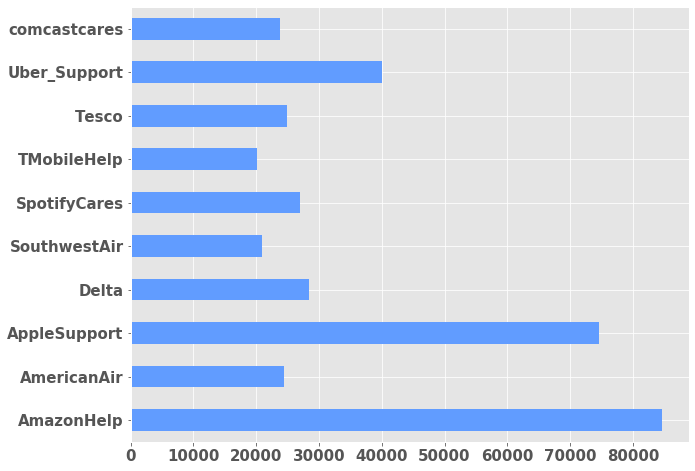

In [798]:
# The number of Customer Service (CS) tweet responses for each company
count = Req_Res.groupby("author_id_y")["text_x"].count()
c = count[count>20000].plot(kind='barh',figsize=(10, 8), color='#619CFF', zorder=2,)# width=width,)
c.set_ylabel('')
# plt.show()

In [532]:
## List all the companies to find all airlines (Sentiment was trained on: American, Delta, SouthWest, United, US Airways, Virgin)
Req_Res["author_id_y"].unique()

array(['sprintcare', 'Ask_Spectrum', 'VerizonSupport', 'ChipotleTweets',
       'AskPlayStation', 'marksandspencer', 'MicrosoftHelps',
       'ATVIAssist', 'AdobeCare', 'AmazonHelp', 'XboxSupport',
       'AirbnbHelp', 'AirAsiaSupport', 'Morrisons', 'NikeSupport',
       'AskAmex', 'YahooCare', 'AskLyft', 'UPSHelp', 'Delta', 'McDonalds',
       'AppleSupport', 'Uber_Support', 'Tesco', 'SpotifyCares',
       'British_Airways', 'comcastcares', 'AmericanAir', 'TMobileHelp',
       'VirginTrains', 'SouthwestAir', 'AskeBay', 'hulu_support',
       'GWRHelp', 'sainsburys', 'AskPayPal', 'HPSupport', 'ChaseSupport',
       'CoxHelp', 'DropboxSupport', 'VirginAtlantic', 'BofA_Help',
       'AzureSupport', 'AlaskaAir', 'ArgosHelpers', 'Postmates_Help',
       'AskTarget', 'GoDaddyHelp', 'CenturyLinkHelp', 'AskPapaJohns',
       'SW_Help', 'nationalrailenq', 'askpanera', 'Walmart',
       'USCellularCares', 'AsurionCares', 'GloCare', 'idea_cares',
       'DoorDash_Help', 'NeweggService', 'VirginA

In [8]:
## For the time being let us stick with AmericanAir services
AmericanAir_Req_Res = Req_Res[Req_Res["author_id_y"]=="AmericanAir"]
DeltaAir_Req_Res = Req_Res[Req_Res["author_id_y"]=="Delta"]
British_Airways_Req_Res = Req_Res[Req_Res["author_id_y"]=="British_Airways"]
SouthwestAir_Req_Res = Req_Res[Req_Res["author_id_y"] == "SouthwestAir"]
VirginAtlantic_Req_Res = Req_Res[Req_Res["author_id_y"] == "VirginAtlantic"]
AlaskaAir_Req_Res = Req_Res[Req_Res["author_id_y"] == "AlaskaAir"]
VirginAmerica_Req_Res = Req_Res[Req_Res["author_id_y"] == "VirginAmerica"]
JetBlue_Req_Res = Req_Res[Req_Res["author_id_y"] == "JetBlue"]


Airline_List = [AmericanAir_Req_Res, DeltaAir_Req_Res, British_Airways_Req_Res, SouthwestAir_Req_Res, VirginAtlantic_Req_Res, AlaskaAir_Req_Res, VirginAmerica_Req_Res, JetBlue_Req_Res]

SUB_Req_Res = pd.concat(Airline_List, axis=0)

SUB_Req_Res.head()

,tweet_id_x,author_id_x,inbound_x,created_at_x,text_x,response_tweet_id_x,in_response_to_tweet_id_x,tweet_id_y,author_id_y,inbound_y,created_at_y,text_y,response_tweet_id_y,in_response_to_tweet_id_y
161,1002,115905,True,Tue Oct 31 22:02:04 +0000 2017,Ben Tennyson and an American Airlines pilot. 🎃...,1001,NaN,1001,AmericanAir,False,Tue Oct 31 22:24:05 +0000 2017,"Aww, that's definitely a future pilot in the ...",NaN,1002.0
162,1005,115906,True,Tue Oct 31 21:51:37 +0000 2017,"I’m sorry, what? It’s going to COST me $50 to ...","1003,1007",NaN,1003,AmericanAir,False,Tue Oct 31 22:22:37 +0000 2017,This is a great option for customers who want...,1004,1005.0
163,1009,115907,True,Tue Oct 31 21:54:22 +0000 2017,Heading to London tonight will be there for 5 ...,"1008,1010,1011,1012,1013,1014,1015,1016,1017,1...",NaN,1008,AmericanAir,False,Tue Oct 31 22:19:34 +0000 2017,"It's always a pleasure to have you on board, ...",NaN,1009.0
164,1062,115908,True,Tue Oct 31 21:47:19 +0000 2017,Check out these tiny trick-or-treaters all dre...,"1061,1063",NaN,1061,AmericanAir,False,Tue Oct 31 22:17:44 +0000 2017,"Pilots, Potter, Pumpkins and Skeletons...oh m...",NaN,1062.0
165,1065,115909,True,Tue Oct 31 21:51:36 +0000 2017,"Thank you, @AmericanAir for playing #ThisIsUs ...",1064,NaN,1064,AmericanAir,False,Tue Oct 31 22:14:35 +0000 2017,We're glad you got to kick back and enjoy a s...,NaN,1065.0


In [9]:
# Interestingly the Data Set has tweets in many languages
# -- Imposing the requirement that we only use tweets written in English

# nlp_cld = spacy.load('en',disable_pipes=["tagger","ner"])
# language_detector = spacy_cld.LanguageDetector()
# nlp_cld.add_pipe(language_detector)

# Creating a mask for the Language Values
mask = []
try:
    for i,doc in tqdm(enumerate(nlp_cld.pipe(SUB_Req_Res["text_x"], batch_size=1024))):
            if 'en' not in doc._.languages or len(doc._.languages) != 1:
                mask.append(False)
            else:
                mask.append(True)
except Exception:
    print("excepted ")

In [10]:
# Applying the mask created above 
# AmericanAir_Req_Res = AmericanAir_Req_Res[mask]
SUB_Req_Res['in_response_to_tweet_id_y'].astype(int)
type(SUB_Req_Res['in_response_to_tweet_id_y'].iloc[0])
# SUB_Req_Res_NoNaN = AmericanAir_Req_Res.dropna(how='all')
# print(SUB_Req_Res_NoNaN.shape)
len(mask), SUB_Req_Res['text_x'].shape
SUB_Req_Res.sample(frac=0.0005)

,tweet_id_x,author_id_x,inbound_x,created_at_x,text_x,response_tweet_id_x,in_response_to_tweet_id_x,tweet_id_y,author_id_y,inbound_y,created_at_y,text_y,response_tweet_id_y,in_response_to_tweet_id_y
653711,2261281,658390,True,Sun Nov 26 14:14:45 +0000 2017,@AlaskaAir Flight 2108 PDX to GEG will put me ...,2261280,NaN,2261280,AlaskaAir,False,Sun Nov 26 14:18:35 +0000 2017,Woohoo!! Thank YOU for your loyalty &amp; sup...,NaN,2261281.0
512967,1830031,549170,True,Tue Oct 17 15:53:48 +0000 2017,@Delta Why is flight DL4873 being delayed?,1830030,NaN,1830030,Delta,False,Tue Oct 17 16:16:46 +0000 2017,"Hi, Melanie. Air traffic control delays in Se...",NaN,1830031.0
851545,2912152,806137,True,Tue Nov 28 18:59:38 +0000 2017,@British_Airways Been sat on the tarmac at Gla...,2912151,NaN,2912151,British_Airways,False,Tue Nov 28 21:48:19 +0000 2017,We're sorry for the long delay and for the wa...,NaN,2912152.0
514802,1835885,550536,True,Wed Oct 18 15:53:51 +0000 2017,Flying from CVG to LHR on Business class fligh...,"1835884,1835886",NaN,1835884,AmericanAir,False,Wed Oct 18 16:01:11 +0000 2017,We're sorry to hear Business Class wasn't ava...,NaN,1835885.0
777401,2667187,751380,True,Tue Nov 21 15:20:34 +0000 2017,@JetBlue I just need to check in my pup! Why a...,2667186,NaN,2667186,JetBlue,False,Tue Nov 21 15:22:24 +0000 2017,"We know long lines can be frustrating, hang i...",NaN,2667187.0
822716,2815092,784830,True,Mon Nov 27 02:32:57 +0000 2017,3 hour + delay in Orlando with @Delta because ...,2815091,NaN,2815091,Delta,False,Mon Nov 27 02:55:07 +0000 2017,"Oh no! I'm sorry for the delay, James. Please...",NaN,2815092.0
839836,2872933,797643,True,Tue Nov 28 03:35:51 +0000 2017,@Delta struggling to make a change to my reser...,2872932,NaN,2872932,Delta,False,Tue Nov 28 03:38:11 +0000 2017,"Hello Kelsey, please DM your confirmation num...",NaN,2872933.0
469196,1690380,513177,True,Mon Nov 06 20:20:55 +0000 2017,@AlaskaAir update: Alaska has told me theyll r...,1690379,NaN,1690379,AlaskaAir,False,Mon Nov 06 20:28:11 +0000 2017,Your refund has been processed. Thanks for ch...,NaN,1690380.0
284483,1043147,366679,True,Thu Oct 12 21:43:12 +0000 2017,@AmericanAir wondering if I should live-tweet ...,1043146,NaN,1043146,AmericanAir,False,Thu Oct 12 22:16:34 +0000 2017,We'll have you to the gate as quickly as we c...,NaN,1043147.0
721040,2483195,709447,True,Sun Oct 29 22:49:13 +0000 2017,I'm thankful for that three seconds of blinkin...,2483194,NaN,2483194,Delta,False,Sun Oct 29 23:47:55 +0000 2017,Thank you for choosing Delta! *TMB,NaN,2483195.0


In [57]:
# Generating The Conversation Array: Contains the Tweet_IDs for each conversations
SUB_Conv = pd.DataFrame([])
SUB_Conv["Author_ID"]   = SUB_Req_Res['author_id_x']      # Adding the Author if the first tweet
SUB_Conv["Tweet_ID_Initial"]  = SUB_Req_Res['tweet_id_x'] # Adding the first tweet's id
SUB_Conv["Full_Response_Tweet_IDs"] = ""
print(SUB_Conv.shape)

for i in range(SUB_Req_Res.shape[0]):
    # Tweets from Company to Customer
    temp_list_x = []
    temp_list_x = SUB_Req_Res['response_tweet_id_x'].iloc[i].split(",")
    temp_list_x = list(map(int, temp_list_x))
    # Tweets from Customer to Company
    temp_list_y = []
    if str(SUB_Req_Res['response_tweet_id_y'].iloc[i]) != 'nan':
        temp_list_y = SUB_Req_Res['response_tweet_id_y'].iloc[i].split(",")
        temp_list_y = list(map(int, temp_list_y))
    # Combining Tweet ID Lists from Customer and Company
    SUB_Conv['Full_Response_Tweet_IDs'].iloc[i] = temp_list_x+temp_list_y

## Saving the Request and Response Dataframe and the Conversational Dataframe
SUB_Req_Res.to_csv('SUB_Req_Res.csv')
SUB_Conv.to_csv('SUB_Conv.csv')

(109033, 3)


In [60]:
SUB_Conv

,Author_ID,Tweet_ID_Initial,Full_Response_Tweet_IDs
161,115905,1002,[1001]
162,115906,1005,"[1003, 1007, 1004]"
163,115907,1009,"[1008, 1010, 1011, 1012, 1013, 1014, 1015, 101..."
164,115908,1062,"[1061, 1063]"
165,115909,1065,[1064]
...,...,...,...
874433,530366,2985656,[2985655]
874506,823320,2985886,"[2985884, 2985885]"
874580,823374,2986096,[2986095]
874740,823488,2986514,"[2986512, 2986513]"


In [ ]:
os.chdir(data_path)
SUB_Req_Res = pd.read_csv("SUB_Req_Res.csv")
SUB_Conv = pd.read_csv("SUB_Conv.csv")

In [62]:
## Now creating a dataframe for ALL Tweets and their corresponding tweet ID
df_Tweets = pd.DataFrame([])
df_Tweets["Author_ID"]  = CS_Tweets_raw['author_id']
df_Tweets["Tweet_ID"]   = CS_Tweets_raw['tweet_id']
df_Tweets["Tweet_Text"] = CS_Tweets_raw["text"]


In [63]:
## Including the time of the tweet in the full 'df_Tweets' dataframe
from datetime import datetime
import time
df_Tweets["Time_Created"] = CS_Tweets_raw["created_at"].apply(lambda x : int(datetime.strptime(x, "%a %b %d %H:%M:%S %z %Y").strftime('%s')))

In [64]:
df_Tweets.columns

Index(['Author_ID', 'Tweet_ID', 'Tweet_Text', 'Time_Created'], dtype='object')

In [ ]:
##################################################################################################
## Sanity Check: Does each Tweet have text attached to it?
##################################################################################################
# cnt = 0
#for i in range(df_Tweets.shape[0]):
#     (df_Tweets.loc[df_Tweets['Tweet_ID'] == Tweet_ID_Temp, 'Tweet_Text'].empty == False)
cnt_empty = 0
for j in range(df_Tweets.shape[0]):
    print("The index =",j)
    Tweet_ID_Temp = df_Tweets.Tweet_ID.iloc[j]
    cnt_empty += int((df_Tweets.loc[df`_Tweets['Tweet_ID'] == Tweet_ID_Temp, 'Tweet_Text'].empty == False))

## Training the Sentiment Analysis Model

In [ ]:
## Now Training the Sentiment Analysis Predictor (devloped in EmotionalSentiment_Data_Analysis_USAirlines.ipynb)

import numpy as np
import os

#Data Analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Data Preprocessing and Feature Engineering
from textblob import TextBlob
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

#Model Selection and Validation
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

In [ ]:
# Importing the dataset with pandas

# Changing the working directory to the raw data directory
os.chdir('/home/george/Documents/Insight_DS_TO20A/Projects/EmotionalDetection/data/raw/US_Airline_Sentiment')
data_temp = pd.read_csv('Tweets.csv')
os.chdir(notebook_path)

In [ ]:
# Minimalist appraoch to labelling the above data set: 
# Create a binary classification scheme = the headline has a "+" or "-" emotional response.
## Only collect the responses that gave a positive or negative emotional response from the airline

# data_pn = data_temp[data_temp.airline_sentiment != 'neutral'] 
# data_pn.airline_sentiment.unique(), data_pn.shape  

# Droping labels with nan and converting them
#data_temp.negativereason_confidence.dropna(how='all',inplace=True)
#data_temp['negativereason_confidence'] = data_temp.negativereason_confidence.round(0).astype(int)
#data_temp.negativereason_confidence.dropna(how='all',inplace=True)
#data_temp.negativereason_confidence.unique()


# # Gathering the text and labels

text = data_temp.text.copy(deep=True)
labels_confvalues = data_temp.negativereason_confidence
labels_confvalues.unique()
# # Pre-processing labels. Removing "inf" and nan
labels_confvalues.replace([np.inf, -np.inf], np.nan)
labels_confvalues.dropna()

# # Seperating the labels by seperating the confidence labels to be:
# # negative > 0.5, positive is <= 0.5
labels_confvalues.dropna(how='all', inplace=True)
labels = labels_confvalues.round(0).astype(int)
filter_text = labels.index
text = text[filter_text]

# Printing the number of each class:
print("The total number of tweets are:", labels.shape[0])
print("The number (out of 5000) of negative emotional headlines =", labels.shape[0] - labels.sum())
print("The number (out of 5000) of positive emotional headlines =", labels.sum())
print("The niave classification (1 class fit to all) is =", 1-2111.0/7397)

In [ ]:
# Forcing a balance dataset -- NIAVELY REMOVING POSITIVE TWEETS To BALANCE THE DATASET

## Splitting the Data into a Training, Validation, and Test Set
## Fractions are: Training = 80%, Validation = 10%, Test = 10 %

from sklearn.model_selection import train_test_split  


## For the time being, the following code forces the training, validation, and test data sets are balanced
num_pos_labels = labels.sum() # 1418 headlines
num_neg_labels = labels.shape[0] - num_pos_labels # 3582 headlines
num_pos_labels_2drop = num_pos_labels - num_neg_labels # 2164 headlines
print(num_pos_labels)
print(num_neg_labels)
print(num_pos_labels_2drop)
# cnt = 0

index_pos = labels[labels == 1].index
index_neg = labels[labels == 0].index
labels_temp_bal_pos = labels[index_pos[num_pos_labels_2drop:]]
labels_temp_bal_neg = labels[index_neg]

labels_temp_bal = labels_temp_bal_neg.combine(labels_temp_bal_pos, max, fill_value=0)

print("The total length of the label series = ", labels_temp_bal.shape)
print("The total number of positive labels =",labels_temp_bal.sum())
labels_temp_bal.loc[14638], labels.loc[14638]

## Ensuring we use the appropriate text from the balanced labeled series
labels_temp_bal_indices = labels_temp_bal.index
text_bal = text[labels_temp_bal_indices]

# cnt = 0
# for i in range(labels_temp_bal.shape[0]):
#     if labels_temp_bal.iloc[i] == 1 and cnt < (num_pos_labels_2drop+1):
#         labels_temp_bal[i].drop(inplace=True)
#         cnt += 1

# index_Label0 = data_temp_bal.index[data_temp_bal['BinaryEmoLabel'] == 0].tolist()


# Labels = data_temp.BinaryEmoLabel
# X_train, X_test, y_train, y_test = train_test_split(data_temp, Labels, test_size=0.2, random_state=1)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=1)

In [ ]:
## Combining all the above text pre-processing into one function 

def text_processing(headline):
    
    #Generating the list of words in the headline (hastags and other punctuations removed)
    def form_sentence(headline):
        headline_blob = TextBlob(headline)
        return ' '.join(headline_blob.words)
    new_headline = form_sentence(headline)
    
    #Removing stopwords and words with unusual symbols
    def no_user_alpha(headline):
        headline_list = [ele for ele in headline.split() if ele != 'user']
        clean_tokens = [t for t in headline_list if re.match(r'[^\W\d]*$', t)]
        clean_s = ' '.join(clean_tokens)
        clean_mess = [word for word in clean_s.split() if word.lower() not in stopwords.words('english')]
        return clean_mess
    no_punc_headline = no_user_alpha(new_headline)
    
    #Normalizing the words in headlines 
    def normalization(headline_list):
        lem = WordNetLemmatizer()
        normalized_headline = []
        for word in headline_list:
            normalized_text = lem.lemmatize(word,'v')
            normalized_headline.append(normalized_text)
        return normalized_headline
    
    
    return normalization(no_punc_headline)

In [ ]:
def Int2EmotionConverter(IntEmo):
    """
    Converts the integer value of the emotion predicted to the emotions word in English
    """
    EmoWords = pd.DataFrame(['Happy','Sad'])
    return EmoWords.iloc[IntEmo][0]

In [ ]:
# scikit-learn: Pre-defining a workflow of algorithm (Niave-Bayse Classifier)
pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=text_processing)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),                      # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [ ]:
### Trainiing Model ####
msg_train, msg_test, label_train, label_test = train_test_split(text_bal, labels_temp_bal, test_size=0.1)
pipeline.fit(msg_train,label_train)
predictions = pipeline.predict(msg_test)
print(classification_report(predictions,label_test))
print(confusion_matrix(predictions,label_test))
print(accuracy_score(predictions,label_test))
# What would the accuracy of the Training Data Set is we niavely set all labels to 0
print("The accuracy of labelling all headlines NEGATIVE is:",1-label_train.sum()/len(label_train))

print("This model's accuracy is better than the Niave assumption by:", accuracy_score(predictions,label_test) - 1+label_train.sum()/len(label_train)) 

In [ ]:
# Tweet_Emo_Preds = pipeline.predict(df_Tweets["Tweet_Text"]) # Predicting the emotions of ALL Tweets (numpy array)

## Returning to the Customer Service Tweets

In [65]:
### LOADING THE EMOTIONAL SENTIMENT LABELS FOR EACH TWEET ###
#np.save('Tweet_Emo_Preds_250120.csv',Tweet_Emo_Preds)
os.chdir(notebook_path)
Tweet_Emo_Preds = np.load("Tweet_Emo_Preds_250120.csv.npy")
df_Tweets["Emotion"] = Tweet_Emo_Preds ## The emotional prediction = "Positive" = 1 , "Negative" = 0
## Replacing the number valued emotions with the associated words: 0 - "Pos" and 1 - "Neg"
df_Tweets['Emotion'] = df_Tweets['Emotion'].replace(0,'Pos')
df_Tweets['Emotion'] = df_Tweets['Emotion'].replace(1,'Neg')
df_Tweets['Emotion'].unique()

array(['Pos', 'Neg'], dtype=object)

In [66]:
df_Tweets.to_csv("df_Tweets.csv")

In [18]:
df_Tweets.columns, SUB_Conv.columns

(Index(['Author_ID', 'Tweet_ID', 'Tweet_Text', 'Time_Created', 'Emotion'], dtype='object'),
 Index(['Author_ID', 'Tweet_ID_Initial', 'Full_Response_Tweet_IDs'], dtype='object'))

In [92]:
SUB_Conv["Convo_Length"] = "" # the number of tweets in the conversations
SUB_Conv["Tweets"] = pd.Series([]) # A list all the tweets in the conversations
SUB_Conv["Emotions"] = pd.Series([]) # A vector of the emotions in chronological order (same order as tweets in "Tweets")
SUB_Conv["Author_ID_List"] = pd.Series([])
SUB_Conv["Final_Convo_Length"] = 0
SUB_Conv["Times_Created"] = pd.Series([])
for i in range(SUB_Conv.shape[0]):
#for i in range(100):
    # Resetting variables
    convo_len = 0 
    Tweet_Text_Temp = [] # declaring/resetting the list for tweet text
    Tweet_Emotion_Temp = [] # declaring/resetting the list for the emotional predictions
    Tweet_Convo_AuthorIDs = [] 
    Tweet_Times_Created = []
    convo_cnt = 0
    
    convo_len = len(SUB_Conv['Full_Response_Tweet_IDs'].iloc[i]) # Conversation length (# of Tweets)
    if convo_len > 0:
        SUB_Conv["Convo_Length"].iloc[i] = convo_len # Saving the Length of the Conversation
        Tweet_IDs_Temp = SUB_Conv.iloc[i].Full_Response_Tweet_IDs # Comversation Tweet IDs
        Initial_Tweet_ID_Temp = SUB_Conv["Tweet_ID_Initial"].iloc[i] # The First Tweet ID
        Initial_Tweet_Time_Created = df_Tweets[df_Tweets["Tweet_ID"] == Initial_Tweet_ID_Temp].Time_Created
        
        if df_Tweets.loc[df_Tweets['Tweet_ID'] == Initial_Tweet_ID_Temp, 'Tweet_Text'].empty == False:
            Tweet_Text_Temp.append((df_Tweets.loc[df_Tweets['Tweet_ID'] == Initial_Tweet_ID_Temp, 'Tweet_Text'].iloc[0])) # First Tweet's Text
            Tweet_Emotion_Temp.append(df_Tweets.loc[df_Tweets['Tweet_ID'] == Initial_Tweet_ID_Temp, 'Emotion'].iloc[0])
            Tweet_Convo_AuthorIDs.append(df_Tweets.loc[df_Tweets['Tweet_ID'] == Initial_Tweet_ID_Temp, 'Author_ID'].iloc[0])
            Tweet_Times_Created.append(df_Tweets.loc[df_Tweets['Tweet_ID'] == Initial_Tweet_ID_Temp, 'Time_Created'].iloc[0])
            for j in range(convo_len):
                Tweet_ID_Temp = Tweet_IDs_Temp[j]
                if (df_Tweets.loc[df_Tweets['Tweet_ID'] == Tweet_ID_Temp, 'Tweet_Text'].empty == False):
                    Tweet_Text_Temp.append( df_Tweets.loc[df_Tweets['Tweet_ID'] == Tweet_ID_Temp, 'Tweet_Text'].iloc[0] )
                    Tweet_Emotion_Temp.append( df_Tweets.loc[df_Tweets['Tweet_ID'] == Tweet_ID_Temp, 'Emotion'].iloc[0] )
                    Tweet_Convo_AuthorIDs.append( df_Tweets.loc[df_Tweets['Tweet_ID'] == Tweet_ID_Temp, 'Author_ID'].iloc[0])
                    Tweet_Times_Created.append(df_Tweets.loc[df_Tweets['Tweet_ID'] == Tweet_ID_Temp, 'Time_Created'].iloc[0])
                    convo_cnt += 1
#                     print(cnt)
    
            SUB_Conv["Tweets"].iloc[i] = Tweet_Text_Temp
#             print(Tweet_Emotion_Temp)
#             print("The type of the Emotion 'list?':", type(Tweet_Emotion_Temp))
#             print("The type of the Tweets 'list'?:", type(Tweet_Text_Temp))
            SUB_Conv["Emotions"].iloc[i] = Tweet_Emotion_Temp # The List of Emotions corresponding to (and preserving the order of) the Tweet_IDs
            SUB_Conv["Author_ID_List"].iloc[i] = Tweet_Convo_AuthorIDs # The list of authors in the order of the Tweet_IDs
            SUB_Conv["Final_Convo_Length"].iloc[i] = convo_cnt # This is the number of tweets that were found to exist for the conversation
            SUB_Conv["Times_Created"].iloc[i] = [str(i) for i in Tweet_Times_Created]
    #else SUB_Conv.drop(SUB_Conv.iloc[i]):
    SUB_Conv.to_csv("SUB_Conv.csv")

In [103]:
#SUB_Conv[0:100]
# df_Tweets.loc[df_Tweets['Tweet_ID'] == Tweet_ID_Temp, 'Author_ID'].iloc[0]
# Tweet_Convo_AuthorIDs
SUB_Conv[SUB_Conv["Final_Convo_Length"] >= 4]

,Author_ID,Tweet_ID_Initial,Full_Response_Tweet_IDs,Convo_Length,Tweets,Emotions,Author_ID_List,Final_Convo_Length,Times_Created
1841,117169,6628,"[6625, 6626, 6627, 6624]",4,[Interacted with one of the rudest flight atte...,"[Neg, Neg, Pos, Neg, Pos]","[117169, AmericanAir, 117169, 117169, 117169]",4,"[1507502576, 1507505052, 1507522482, 150752255..."
10777,125116,41480,"[41476, 41477, 41478, 41479]",4,[@AmericanAir flight 1530 from CLT to BOS an e...,"[Pos, Pos, Neg, Neg, Neg]","[125116, AmericanAir, 125116, 125116, 125116]",4,"[1511398214, 1511399596, 1511399949, 151139984..."
14162,128010,53240,"[53236, 53237, 53238, 53239]",4,[So @AmericanAir SUCKS!! I had to buy a whole ...,"[Pos, Pos, Pos, Pos, Pos]","[128010, AmericanAir, 128010, 128010, 128010]",4,"[1509575060, 1509576000, 1509576216, 150957614..."
18765,132229,72284,"[72278, 72286, 72287, 72288, 72289, 72290, 722...",53,[Why Customer service agents from @AmericanAir...,"[Neg, Neg, Pos, Pos, Neg, Pos, Neg]","[132229, AmericanAir, 132230, 132231, 132233, ...",6,"[1512055209, 1512055697, 1512056079, 151205998..."
21224,134436,83903,"[83900, 83899, 83901, 83902]",4,[Unbelievable @AmericanAir how u treat loyal c...,"[Neg, Pos, Neg, Neg, Pos]","[134436, AmericanAir, 134436, 134436, 134436]",4,"[1512067006, 1512067085, 1512067758, 151206760..."
...,...,...,...,...,...,...,...,...,...
790791,761350,2711676,"[2711674, 2711678, 2711679, 2711675]",4,[@JetBlue what the fuck is going on with fligh...,"[Neg, Neg, Neg, Pos, Neg]","[761350, JetBlue, JetBlue, JetBlue, 761350]",4,"[1511160120, 1511160949, 1511160410, 151116040..."
831063,791053,2843453,"[2843447, 2843454, 2843448, 2843449, 2843450, ...",7,[Keep in mind that 50% of lgbtq community is b...,"[Pos, Pos, Pos, Pos, Pos, Pos, Pos]","[791053, JetBlue, 791055, 791056, 791057, 7910...",6,"[1511820840, 1511821031, 1511827799, 151182648..."
831070,791053,2843484,"[2843485, 2843474, 2843486, 2843475, 2843476, ...",12,"[.@JetBlue, why do you have https://t.co/ImXFW...","[Pos, Neg, Pos, Pos, Pos, Pos, Pos, Pos, Pos, ...","[791053, JetBlue, 791056, 465068, 791064, 7910...",10,"[1511817061, 1511819985, 1511825286, 151182446..."
832339,791053,2847821,"[2847817, 2847818, 2847819, 2847820]",4,[Time to update your filter. You are blocking ...,"[Pos, Pos, Pos, Pos, Pos]","[791053, JetBlue, 614882, 792013, 791056]",4,"[1511821213, 1511823082, 1511824773, 151182449..."


In [136]:
## Now ordering the tweets text in chornological ordering
# This should include: The Emotional Lists, The Tweet_IDs
len(SUB_Conv[SUB_Conv["Final_Convo_Length"] == 5])

546

In [141]:
# Checking to see if there are duplicate rows
len(SUB_Conv['Tweet_ID_Initial'].unique()), SUB_Conv.shape[0]
# test = SUB_Conv.drop_duplicates(inplace=False, keep=False)
SUB_Conv_Unique =  SUB_Conv.drop_duplicates(subset='Tweet_ID_Initial', keep="first", inplace=False)

In [142]:
SUB_Conv_Unique.shape, SUB_Conv.shape

((100321, 9), (109033, 9))

In [197]:
## Removing Conversations which have more than two Authors
# len(np.unique(SUB_Conv['Author_ID_List'].iloc[i]))
SUB_Conv_Unique["Author_Num"] = SUB_Conv_Unique["Author_ID_List"].apply(lambda x: len(np.unique(x)))
SUB_Conv_2PerUnique = SUB_Conv_Unique[SUB_Conv_Unique["Author_Num"] == 2]

In [198]:
SUB_Conv_2PerUnique.shape

(97663, 10)

In [203]:
SUB_Conv_2PerUnique[SUB_Conv_2PerUnique["Final_Convo_Length"] >= 5].head(5)

,Author_ID,Tweet_ID_Initial,Full_Response_Tweet_IDs,Convo_Length,Tweets,Emotions,Author_ID_List,Final_Convo_Length,Times_Created,Author_Num
33827,146220,134131,"[134127, 134124, 134128, 134129, 134130]",5,[@AmericanAir I recently flew on your aircraft...,"[Pos, Neg, Neg, Neg, Neg, Pos]","[146220, AmericanAir, 146220, 146220, 146220, ...",5,"[1511528995, 1511529238, 1511530513, 151153047...",2
52206,163669,201826,"[201819, 201818, 201820, 201821, 201822, 20182...",8,[Hey @AmericanAir flight 3513 ORD-ABQ no trash...,"[Neg, Neg, Neg, Neg, Neg, Neg, Neg, Pos, Neg]","[163669, AmericanAir, 163669, 163669, 163669, ...",8,"[1507149934, 1507150698, 1507150931, 150715091...",2
53466,164844,206286,"[206279, 206280, 206281, 206282, 206278, 20628...",8,[I had the worst experience of my life flying ...,"[Neg, Pos, Pos, Neg, Pos, Neg, Neg, Pos, Neg]","[164844, AmericanAir, 164844, 164844, 164844, ...",8,"[1509587578, 1509589626, 1509590788, 150959044...",2
58124,169306,223186,"[223182, 223183, 223181, 223184, 223185]",5,"[@AmericanAir first time to travel with you, s...","[Neg, Pos, Neg, Neg, Neg, Neg]","[169306, AmericanAir, 169306, 169306, 169306, ...",5,"[1507186572, 1507188195, 1507190340, 150719059...",2
73372,183256,282318,"[282311, 282312, 282310, 282313, 282314, 28231...",8,[Tweet catharsis @AmericanAir @126119: a serie...,"[Neg, Neg, Pos, Pos, Pos, Pos, Neg, Neg, Neg]","[183256, AmericanAir, 183256, 183256, 183256, ...",8,"[1507304369, 1507305643, 1507306057, 150730609...",2


In [574]:
# Chronologically ordering Tweets and corresponding sentiment
# NOTE: ensure the tweets are ordered chronologically
# SUB_Conv_2PerUnique['Times_Created']
# i = 33827

SUB_Conv_2PerUnique['Times_Created_Sorted'] = pd.Series([]) 
SUB_Conv_2PerUnique['Emotions_Sorted'] = pd.Series([]) 
SUB_Conv_2PerUnique['Tweets_Sorted'] = pd.Series([])
SUB_Conv_2PerUnique['Author_ID_List_Sorted'] = pd.Series([])

for i in range(SUB_Conv_2PerUnique.shape[0]):
    temp_tweet_ID_initial = SUB_Conv_2PerUnique['Tweet_ID_Initial'].iloc[i]
    # Time Ordering Array
    temp_times = pd.to_numeric(SUB_Conv_2PerUnique[SUB_Conv_2PerUnique['Tweet_ID_Initial'] == temp_tweet_ID_initial ]['Times_Created'].iloc[0])
    temp_index = np.argsort(temp_times)
    times_ordered = temp_times[temp_index]
    
    # Array Chronologically Reordering
    temp_Emos = SUB_Conv_2PerUnique[SUB_Conv_2PerUnique['Tweet_ID_Initial'] == temp_tweet_ID_initial ]['Emotions']
    temp_Emos_ordered = [ temp_Emos.iloc[0][i] for i in temp_index]
    temp_Tweets = SUB_Conv_2PerUnique[SUB_Conv_2PerUnique['Tweet_ID_Initial'] == temp_tweet_ID_initial]['Tweets']
    temp_Tweets_ordered = [temp_Tweets.iloc[0][i] for i in temp_index]
    temp_Author_list = SUB_Conv_2PerUnique[SUB_Conv_2PerUnique['Tweet_ID_Initial'] == temp_tweet_ID_initial ]['Author_ID_List'] 
    temp_Author_list_ordered = [temp_Author_list.iloc[0][i] for i in temp_index]
    
    SUB_Conv_2PerUnique['Times_Created_Sorted'].iloc[i] = list(times_ordered.astype(str)) # pd.Series(np.ndarray.tolist(times_ordered))
    SUB_Conv_2PerUnique['Emotions_Sorted'].iloc[i] = temp_Emos_ordered
    SUB_Conv_2PerUnique['Tweets_Sorted'].iloc[i] = temp_Tweets_ordered
    SUB_Conv_2PerUnique['Author_ID_List_Sorted'].iloc[i] = temp_Author_list_ordered
    
#RO_Emos = test_Emos[temp]
# print('The index array for chrono-ordering:',temp)
# print('The ORIGINAL array of time-stamps:',res)
# print('The ORDERED array of time-stamps:',test_array)
# print('The ORIGINAL array of Emotions:', temp_Emos)
# print('The ORDERED array of Emotions:',temp_Emos_new)
#SUB_Conv_2PerUnique["Emotions_Sorted"].apply(lambda x :[0 if x=='Pos' else 1 for x in x] ) # Converting the 'Pos'/'Neg' to '0/1'
print("Completed!!")

Completed!!


In [577]:
SUB_Conv_2PerUnique.to_csv('SUB_Conv_2PerUnique.csv')

In [575]:
temp_Author_list.iloc[0], temp_Author_list_ordered 

(['366805', 'JetBlue'], ['366805', 'JetBlue'])

In [588]:
SUB_Conv_2PerUnique.iloc[1]

Author_ID                                                             115906
Tweet_ID_Initial                                                        1005
Full_Response_Tweet_IDs                                   [1003, 1007, 1004]
Convo_Length                                                               3
Tweets                     [I’m sorry, what? It’s going to COST me $50 to...
Emotions                                                     [Neg, Pos, Pos]
Author_ID_List                                 [115906, AmericanAir, 115906]
Final_Convo_Length                                                         2
Times_Created                           [1509501097, 1509502957, 1509503088]
Author_Num                                                                 2
Times_Created_Sorted                    [1509501097, 1509502957, 1509503088]
Emotions_Sorted                                              [Neg, Pos, Pos]
Emotions_Sorted_Ints                                               [1, 0, 0]

In [478]:
# Converting the String Emotions to integer values
# SUB_Conv_2PerUnique["Emotions_Sorted"].apply(lambda x :[0 if x=='Pos' else 1 for x in x] ) # Converting the 'Pos'/'Neg' to '0/1'
# df_test = SUB_Conv_2PerUnique.copy(deep=True)
# df_test['Emotions_Sorted'].apply(lambda x : [0 if x=='Pos' else 1 for x in x])
SUB_Conv_2PerUnique['Emotions_Sorted_Ints'] = SUB_Conv_2PerUnique['Emotions_Sorted'].apply(lambda x : [0 if x=='Pos' else 1 for x in x])
SUB_Conv_2PerUnique['Emotions_Sorted_Ints']

161          [0, 0]
162       [1, 0, 0]
163          [1, 0]
164          [0, 0]
165          [1, 0]
            ...    
874433       [0, 0]
874506    [0, 0, 0]
874580       [0, 0]
874740    [0, 0, 0]
874900       [0, 0]
Name: Emotions_Sorted_Ints, Length: 97663, dtype: object

In [537]:
# Now adding the all the emotional (integer) lists together
from operator import add
from itertools import zip_longest
sum_list = []
for i in range(SUB_Conv_2PerUnique.shape[0]):
    list_temp = SUB_Conv_2PerUnique['Emotions_Sorted_Ints'].iloc[i]
    sum_list = [sum(n) for n in zip_longest(sum_list, list_temp, fillvalue=0)]

In [650]:
## Labelling the conversations
# NOTE: The conversations will be labelled according to the sentiment of the final tweet sent by the customer
SUB_Conv_2PerUnique['Conversation_Label'] = pd.Series([])
for i in range(SUB_Conv_2PerUnique.shape[0]):
    temp_customer_ID = SUB_Conv_2PerUnique['Author_ID'].iloc[i]
    Tweet_Author_List = SUB_Conv_2PerUnique['Author_ID_List_Sorted'].iloc[i]
    customer_tweet_index = [j for j in range(len(Tweet_Author_List)) if Tweet_Author_List[j] == temp_customer_ID]
    Final_customer_tweet_index = max(customer_tweet_index)
    SUB_Conv_2PerUnique["Conversation_Label"].iloc[i] = np.int( SUB_Conv_2PerUnique['Emotions_Sorted_Ints'].iloc[i][Final_customer_tweet_index] )
    

## Basic Conversation Analysis -- THINK MVP!!!!
#### The basic analysis of a conversation can begin by asking "How many 'negative' tweets occured through out the conversation?" (STANDARDIZED BY THE LENGTH OF THE CONVERSATION) This can be applied to both the 'positive' and 'negative' conversations. The 'positive' conversation serves as a baseline to which some value between the 'positive' and 'negative' conversations can serve as the threshold which if suprpassed during the the conversation a warning is flagged for the CS agent

[0.         1.         0.5        0.33333333 0.75       0.66666667
 0.8        0.25       0.875      0.4        0.54545455 0.28571429
 0.16666667 0.2        0.45454545 0.375      0.71428571 0.6
 0.42857143 0.76923077 0.7        0.57142857 0.14285714 0.85714286
 0.83333333 0.61538462 0.77777778 0.44444444 0.125      0.11111111
 0.22222222 0.46666667 0.625      0.9        0.64285714 0.86363636
 0.3       ]
The Kuiper Statistic is: 0.3309959919518341
The Kuiper Probability of being draw from the same distribution: 0.0


/home/george/Documents/Insight_DS_TO20A/Projects/EmotionalDetection/notebooks/kuiper.py:64: RuntimeWarning: invalid value encountered in double_scalars
  if abs(S1-so)/(abs(S1)+abs(so))<term_eps or abs(S1-so)<abs_eps:
/home/george/Documents/Insight_DS_TO20A/Projects/EmotionalDetection/notebooks/kuiper.py:71: RuntimeWarning: invalid value encountered in double_scalars
  if abs(S2-so)/(abs(S2)+abs(so))<term_eps or abs(S1-so)<abs_eps:


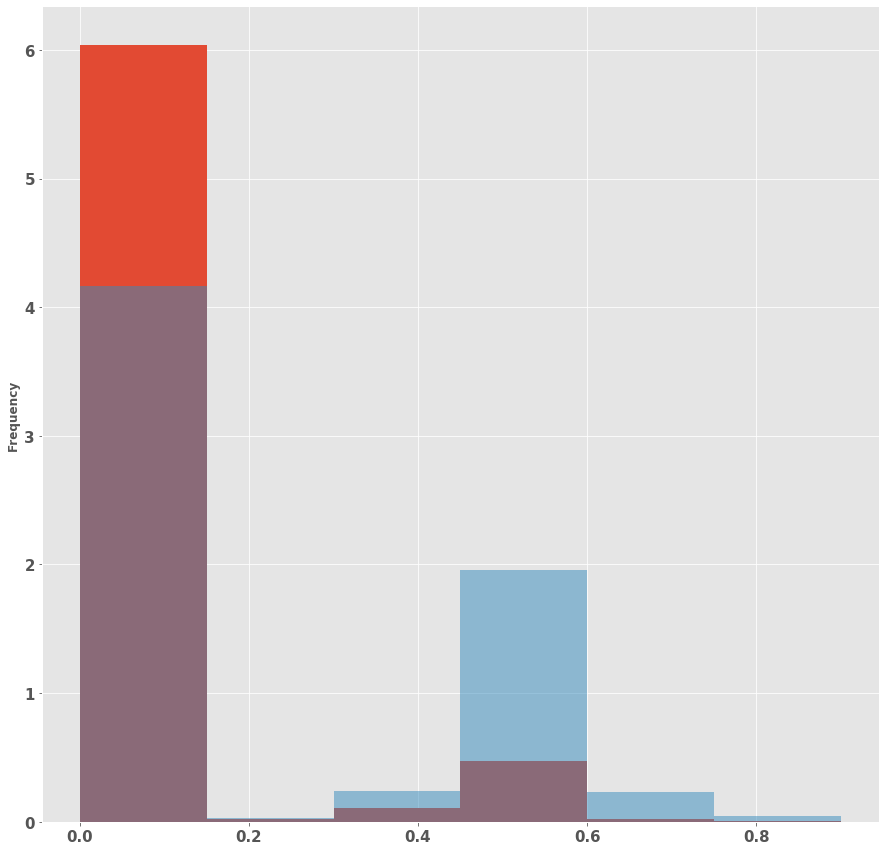

In [791]:
## The Average "Sentiment" value for each conversation (sum of sentiment values divided by the total length of the conversation)

SUB_Conv_2PerUnique['Sentiment_Value'] = SUB_Conv_2PerUnique['Emotions_Sorted_Ints'].apply(lambda x: (sum(x)-x[0])/(len(x)-1))
print(SUB_Conv_2PerUnique['Sentiment_Value'].unique())
#len(SUB_Conv_2PerUnique['Emotions_Sorted_Ints'].iloc[7]), sum(SUB_Conv_2PerUnique['Emotions_Sorted_Ints'].iloc[7])

## Seperating the Resolved from the Unresolved Conversations
SUB_Conv_Resolved   = SUB_Conv_2PerUnique[SUB_Conv_2PerUnique['Conversation_Label'] == 0]
SUB_Conv_UNResolved = SUB_Conv_2PerUnique[SUB_Conv_2PerUnique['Conversation_Label'] == 1]

# Plotting the histograms of the 'Sentiment Values' for Resolved and Unresolved conversations
bins_set = np.arange(0,1,0.15)
#print(bins_set)
SUB_Conv_Resolved['Sentiment_Value'].plot.hist(bins=bins_set, figsize=(15,15),label='Resolved',density=True)
SUB_Conv_UNResolved['Sentiment_Value'].plot.hist(bins=bins_set, alpha=0.5, figsize=(15,15), label='Unresolved', density=True)

# Importing and testing the distributions using a kuiper two test
from kuiper import kuiper_two
epsilon = 10**(-10)
D, fpp = kuiper_two(SUB_Conv_Resolved['Sentiment_Value'], SUB_Conv_UNResolved['Sentiment_Value'])
print("The Kuiper Statistic is:", D)
print("The Kuiper Probability of being draw from the same distribution:", fpp)

# Examining the distributions using simple Gaussian Statisics
# Res_mean = np.mean(SUB_Conv_Resolved['Sentiment_Value'])
# Res_Std  = np.std(SUB_Conv_Resolved['Sentiment_Value'])
# UnRes_mean = np.mean(SUB_Conv_UNResolved['Sentiment_Value'])
# UnRes_Std = np.std(SUB_Conv_UNResolved['Sentiment_Value'])
# print("ResMEAN = ", Res_mean)
# print("ResSTD = ", Res_Std)
# Res3SIG_UB = Res_mean + 3*Res_Std
# print("Res3SIG_UB = ", Res3SIG_UB)
# print("UnResMEAN = ", UnRes_mean)
# print("UnResSTD = ", UnRes_Std)

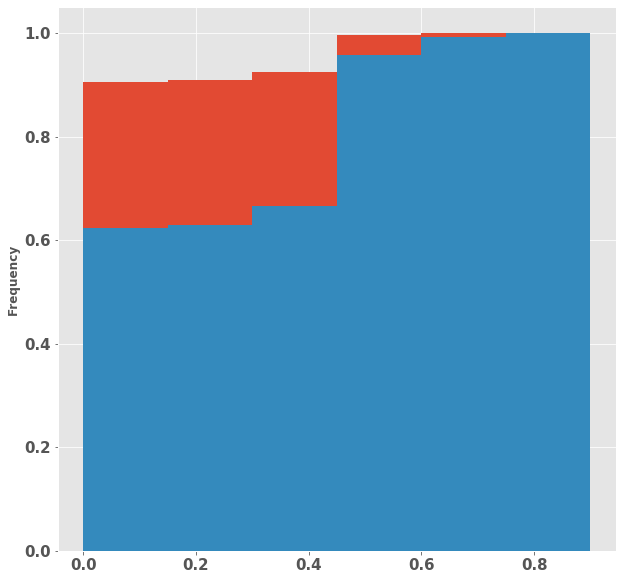

In [792]:

# plotting the cumulative distribution functions
SUB_Conv_Resolved['Sentiment_Value'].plot.hist(bins=bins_set, figsize=(10,10),label='Resolved',cumulative=True,density=True)
SUB_Conv_UNResolved['Sentiment_Value'].plot.hist(bins=bins_set,figsize=(10,10), label='Unresolved',cumulative=True,density=True)


In [657]:
SUB_Conv_2PerUnique.iloc[7]

Author_ID                                                             116144
Tweet_ID_Initial                                                        1922
Full_Response_Tweet_IDs                                   [1920, 1933, 1921]
Convo_Length                                                               3
Tweets                     [Trying to book a flight on @AmericanAir and a...
Emotions                                                     [Neg, Neg, Neg]
Author_ID_List                                 [116144, AmericanAir, 116144]
Final_Convo_Length                                                         2
Times_Created                           [1509502827, 1509504195, 1509505433]
Author_Num                                                                 2
Times_Created_Sorted                    [1509502827, 1509504195, 1509505433]
Emotions_Sorted                                              [Neg, Neg, Neg]
Emotions_Sorted_Ints                                               [1, 1, 1]

In [748]:
i = 20
SUB_Conv_Unique.iloc[i], SUB_Conv_Unique.iloc[i].Tweets

(Author_ID                                                             116571
 Tweet_ID_Initial                                                        3603
 Full_Response_Tweet_IDs                                   [3604, 3601, 3605]
 Convo_Length                                                               3
 Tweets                     [@AmericanAir I just got off one of your fligh...
 Emotions                                                     [Pos, Pos, Neg]
 Author_ID_List                                 [116571, AmericanAir, 116571]
 Final_Convo_Length                                                         2
 Times_Created                           [1511672283, 1511672633, 1511672880]
 Author_Num                                                                 2
 Name: 1013, dtype: object,
 ['@AmericanAir I just got off one of your flights AA1792 from Portland. The gentlemen in front of my 3 year old son, decided to rip at his feet for pressing them against his seat. When I conf

Twitter Conversations with 3 or more Tweets= 37306
The Kuiper Statistic is: 0.6534703496546534
The Kuiper Probability of being draw from the same distribution: 0.0


/home/george/Documents/Insight_DS_TO20A/Projects/EmotionalDetection/notebooks/kuiper.py:64: RuntimeWarning: invalid value encountered in double_scalars
  if abs(S1-so)/(abs(S1)+abs(so))<term_eps or abs(S1-so)<abs_eps:
/home/george/Documents/Insight_DS_TO20A/Projects/EmotionalDetection/notebooks/kuiper.py:71: RuntimeWarning: invalid value encountered in double_scalars
  if abs(S2-so)/(abs(S2)+abs(so))<term_eps or abs(S1-so)<abs_eps:


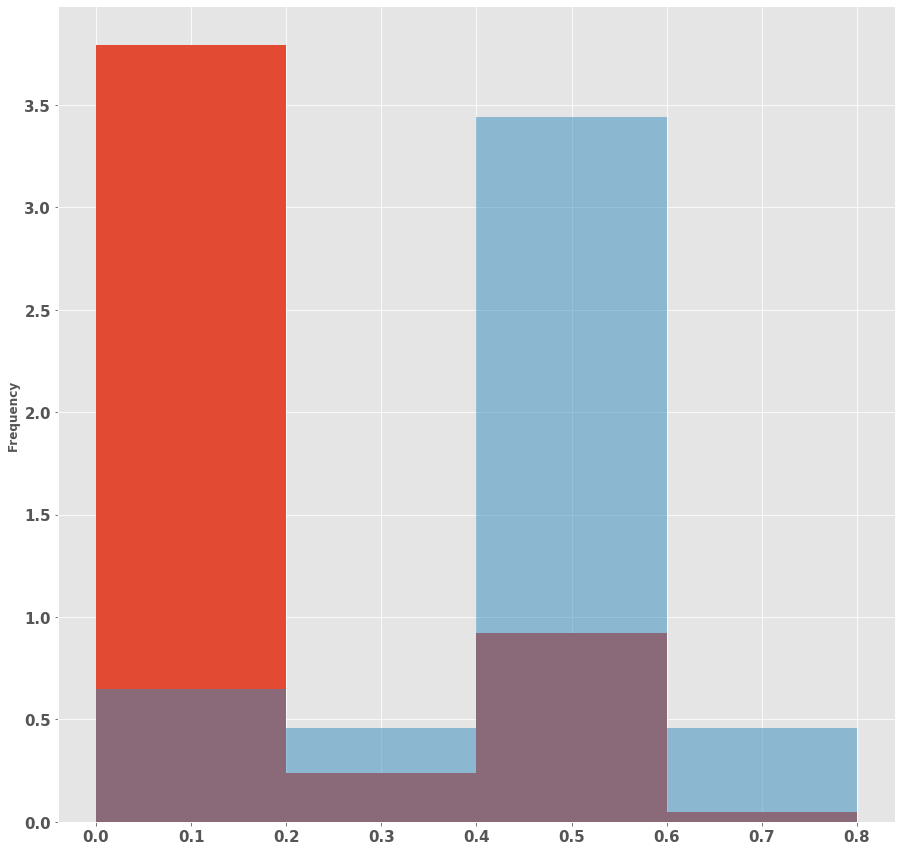

In [806]:
## Now collecting the longer conversations (take notice that the maximum conversation length is 8 tweets after initiation (9 in total))
# Begin with labelling all Tweets as resolved or not -- [resolved,unresolved] = [1,0] and non_issue = -1 (spam/comment etc.)
# NOTE: This is done manually by George J. Conidis 

# Selecting Tweeter Conversations longer than 3 Tweets
SUB_Conv_2PerUnique_MORE = SUB_Conv_2PerUnique[SUB_Conv_2PerUnique["Final_Convo_Length"] >= 2]
print("Twitter Conversations with 3 or more Tweets=", SUB_Conv_2PerUnique_MORE.shape[0])

## Seperating the Resolved from the Unresolved Conversations
SUB_Conv_MORE_Resolved   = SUB_Conv_2PerUnique_MORE[SUB_Conv_2PerUnique_MORE['Conversation_Label'] == 0]
SUB_Conv_MORE_UNResolved = SUB_Conv_2PerUnique_MORE[SUB_Conv_2PerUnique_MORE['Conversation_Label'] == 1]

# Plotting the histograms of the 'Sentiment Values' for Resolved and Unresolved conversations
bins_set = np.arange(0,1,0.2)
#print(bins_set)
SUB_Conv_MORE_Resolved['Sentiment_Value'].plot.hist(bins=bins_set, figsize=(15,15),label='Resolved',density=True)
SUB_Conv_MORE_UNResolved['Sentiment_Value'].plot.hist(bins=bins_set, alpha=0.5, figsize=(15,15), label='Unresolved', density=True)

# Importing and testing the distributions using a kuiper two test
from kuiper import kuiper_two
epsilon = 10**(-10)
D, fpp = kuiper_two(SUB_Conv_MORE_Resolved['Sentiment_Value'], SUB_Conv_MORE_UNResolved['Sentiment_Value'])
print("The Kuiper Statistic is:", D)
print("The Kuiper Probability of being draw from the same distribution:", fpp)


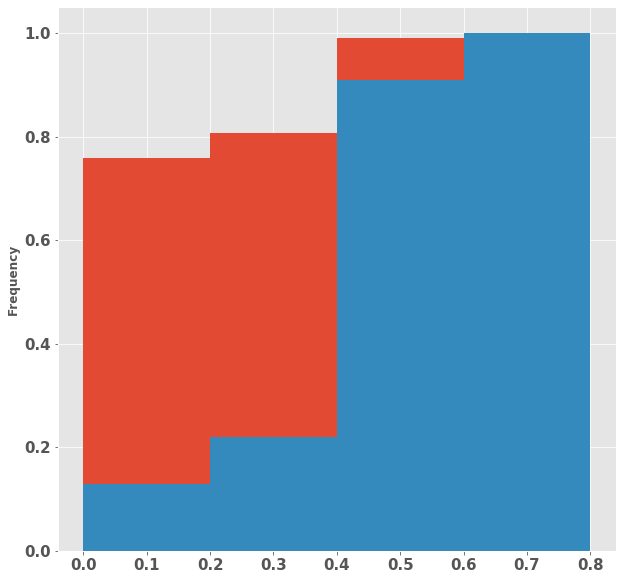

In [807]:


# plotting the cumulative distribution functions
SUB_Conv_MORE_Resolved['Sentiment_Value'].plot.hist(bins=bins_set, figsize=(10,10),label='Resolved',cumulative=True,density=True)
SUB_Conv_MORE_UNResolved['Sentiment_Value'].plot.hist(bins=bins_set,figsize=(10,10), label='Unresolved',cumulative=True,density=True)


In [771]:
i = 41
SUB_Conv_Unique_5Tweets.iloc[i], SUB_Conv_Unique_5Tweets.Tweets.iloc[i], print(Labels_5Tweets['Label_Conv_Res1_Unres0'].iloc[i]), SUB_Conv_Unique_5Tweets["Convo_Length"].iloc[i]

0


(Author_ID                                                             165865
 Tweet_ID_Initial                                                      210700
 Full_Response_Tweet_IDs                             [210698, 210697, 210699]
 Convo_Length                                                               3
 Tweets                     [Startled awake at 5AM today (twice) by @Ameri...
 Emotions                                                [Neg, Pos, Neg, Pos]
 Author_ID_List                         [165865, AmericanAir, 165865, 165865]
 Final_Convo_Length                                                         3
 Times_Created               [1507141031, 1507141360, 1507146120, 1507146071]
 Author_Num                                                                 2
 Times_Created_Sorted        [1507141031, 1507141360, 1507146071, 1507146120]
 Emotions_Sorted                                         [Neg, Pos, Pos, Neg]
 Emotions_Sorted_Ints                                           

In [ ]:
## Feature Engineering and Applying a Model to Predict "WHEN" a Conversation has "at Risk" to be unresolved
